In [21]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from pyswarm import pso
from sklearn.model_selection import ParameterGrid, train_test_split
from geneticalgorithm import geneticalgorithm as ga

In [2]:
# Load data
df = pd.read_excel("coal_new.xlsx")
df

,Year,Coal Production,Coal Consumption
0,1973-01-01,49901.000,50578.608
1,1973-02-01,46461.000,45564.808
2,1973-03-01,51188.000,45402.955
3,1973-04-01,47580.000,43326.498
4,1973-05-01,52061.000,43999.759
...,...,...,...
619,2024-08-01,47110.135,42420.240
620,2024-09-01,45723.696,34504.966
621,2024-10-01,44295.355,30748.724
622,2024-11-01,40963.870,29732.855


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Year              624 non-null    datetime64[ns]
 1   Coal Production   624 non-null    float64       
 2   Coal Consumption  624 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 14.8 KB


In [3]:
scaler = MinMaxScaler()
data = scaler.fit_transform(df[['Coal Production']].values)

In [4]:
train_data, test_data  = train_test_split(data, test_size=0.1,shuffle = False)
train_data.shape, test_data.shape

((561, 1), (63, 1))

In [5]:
sequence_length = 12
num_epochs = 200
batch_size = 32

In [6]:
class StockDataset(Dataset):
    def __init__(self, data, seq_len):
        self.x = []
        self.y = []
        for i in range(len(data) - seq_len):
            self.x.append(data[i:i+seq_len])
            self.y.append(data[i+seq_len])
        self.x = torch.tensor(np.array(self.x), dtype=torch.float32)
        self.y = torch.tensor(np.array(self.y), dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataset = StockDataset(data, sequence_length)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [7]:
train_dataset = StockDataset(train_data, sequence_length)
test_dataset = StockDataset(test_data, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

MODELLING ARSITEKTUR

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, dropout=0.1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, dropout=dropout if num_layers > 1 else 0.0, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

### PSO

In [30]:
import matplotlib.pyplot as plt
import copy


# SPLIT KHUSUS UNTUK PSO (train_pso / val_pso)
train_data_pso, val_data_pso = train_test_split(train_data, test_size=0.2, shuffle=False)
train_dataset_pso = StockDataset(train_data_pso, sequence_length)
val_dataset_pso = StockDataset(val_data_pso, sequence_length)

train_loader_pso = DataLoader(train_dataset_pso, batch_size=batch_size, shuffle=False)
val_loader_pso = DataLoader(val_dataset_pso, batch_size=batch_size, shuffle=False)

def train_model(hidden_size, num_layers, dropout, learning_rate):
    hidden_size = int(hidden_size)
    num_layers = int(num_layers)
    dropout = float(dropout)
    learning_rate = float(learning_rate)

    model = LSTMModel(hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
    model.train()
    criterion = nn.MSELoss(reduction="mean")
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')
    best_model_state = None
    patience = 5
    trigger = 0
    val_losses = []

    for epoch in range(50):
        model.train()
        for x_batch, y_batch in train_loader_pso:
            output = model(x_batch)
            loss = criterion(output, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        val_preds, val_trues = [], []
        with torch.no_grad():
            for x_val, y_val in val_loader_pso:
                out = model(x_val)
                val_preds.extend(out.view(-1).cpu().numpy())
                val_trues.extend(y_val.view(-1).cpu().numpy())

        val_preds = scaler.inverse_transform(np.array(val_preds).reshape(-1, 1)).flatten()
        val_trues = scaler.inverse_transform(np.array(val_trues).reshape(-1, 1)).flatten()
        val_loss = mean_absolute_error(val_trues, val_preds)
        val_losses.append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            trigger += 1
            if trigger >= patience:
                # print(f"⛔ Early stopped at epoch {epoch+1}")
                break
    
    torch.save(best_model_state, 'best_model_pso.pt')
    
    return best_val_loss

In [67]:
#model.load_state_dict(torch.load('best_model_pso.pt'))
#model.eval()

In [31]:
# 3. Fungsi Wrapper untuk PSO
def pso_objective(x):
    hidden_size, num_layers, dropout, lr = x
    try:
        return train_model(hidden_size, num_layers, dropout, lr)
    except:
        return 99999  # penalti jika gagal training

In [69]:
# 4. PSO Parameter Search
lb = [16, 1, 0.2, 0.0001]  # lower bounds: hidden, layer, dropout, lr
ub = [64, 2, 0.3, 0.01]    # upper bounds

best_params, _ = pso(pso_objective, lb, ub, swarmsize=10, maxiter=5)
hidden_size, num_layers, dropout, lr = best_params
print("✅ Best Parameters: ", best_params)

Stopping search: maximum iterations reached --> 5
✅ Best Parameters:  [4.11638655e+01 1.00000000e+00 2.79987499e-01 6.90063505e-04]


In [70]:
hidden_size = int(round(float(hidden_size)))
num_layers = int(round(float(num_layers)))
dropout = float(dropout)  # dropout tetap float
lr1 = float(lr)            # learning rate tetap float

model = LSTMModel()
model.train()
criterion = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [71]:

for epoch in range(num_epochs):
    for x_batch, y_batch in train_loader:
        output = model(x_batch)
        loss = criterion(output, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")


Epoch [10/200], Loss: 0.032991
Epoch [20/200], Loss: 0.006192
Epoch [30/200], Loss: 0.004846
Epoch [40/200], Loss: 0.004475
Epoch [50/200], Loss: 0.004101
Epoch [60/200], Loss: 0.003780
Epoch [70/200], Loss: 0.003509
Epoch [80/200], Loss: 0.003283
Epoch [90/200], Loss: 0.003093
Epoch [100/200], Loss: 0.002928
Epoch [110/200], Loss: 0.002779
Epoch [120/200], Loss: 0.002645
Epoch [130/200], Loss: 0.002539
Epoch [140/200], Loss: 0.002460
Epoch [150/200], Loss: 0.002392
Epoch [160/200], Loss: 0.002329
Epoch [170/200], Loss: 0.002268
Epoch [180/200], Loss: 0.002212
Epoch [190/200], Loss: 0.002163
Epoch [200/200], Loss: 0.002124


In [72]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    # Hindari pembagian dengan nol
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_idx = y_true != 0
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

def evaluate_model(model, data_loader, scaler):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            output = model(x_batch)

            y_true.extend(y_batch.view(-1).numpy())
            y_pred.extend(output.view(-1).numpy())

    # Inverse transform
    y_true = scaler.inverse_transform(np.array(y_true).reshape(-1, 1)).flatten()
    y_pred = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return mae, rmse, mape, y_true, y_pred

mae_train, rmse_train, mape_train, y_train_true, y_train_pred = evaluate_model(model, train_loader, scaler)
mae_test, rmse_test, mape_test, y_test_true, y_test_pred = evaluate_model(model, test_loader, scaler)

print("\n📊 Evaluasi:")
print(f"Training -> MAE: {mae_train:.2f}, RMSE: {rmse_train:.2f}, MAPE: {mape_train:.2f}%")
print(f"Testing  -> MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}, MAPE: {mape_test:.2f}%")



📊 Evaluasi:
Training -> MAE: 4396.64, RMSE: 6190.90, MAPE: 6.51%
Testing  -> MAE: 2795.16, RMSE: 3555.70, MAPE: 6.28%


In [73]:
# Save full model
torch.save(model.state_dict(), "pso_model_12.pth")
print("✅ Model berhasil disimpan")


✅ Model berhasil disimpan


### GridSearch

In [27]:
def train_model(hidden_size, num_layers, dropout, learning_rate):
    hidden_size = int(hidden_size)
    num_layers = int(num_layers)
    dropout = float(dropout)
    learning_rate = float(learning_rate)

    # SPLIT SEPERTI PSO
    train_data_gs, val_data_gs = train_test_split(train_data, test_size=0.2, shuffle=False)
    train_dataset = StockDataset(train_data_gs, sequence_length)
    val_dataset = StockDataset(val_data_gs, sequence_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = LSTMModel(hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
    model.train()
    criterion = nn.MSELoss(reduction="mean")
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')
    best_model_state = None
    patience = 5
    trigger = 0

    for epoch in range(50):
        model.train()
        for x_batch, y_batch in train_loader:
            output = model(x_batch)
            loss = criterion(output, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        val_preds, val_trues = [], []
        with torch.no_grad():
            for x_val, y_val in val_loader:
                out = model(x_val)
                val_preds.extend(out.view(-1).cpu().numpy())
                val_trues.extend(y_val.view(-1).cpu().numpy())

        val_preds = scaler.inverse_transform(np.array(val_preds).reshape(-1, 1)).flatten()
        val_trues = scaler.inverse_transform(np.array(val_trues).reshape(-1, 1)).flatten()
        val_loss = mean_absolute_error(val_trues, val_preds)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            trigger += 1
            if trigger >= patience:
                break

    return best_val_loss, best_model_state


In [28]:
# 5. GRID SEARCH
param_grid = {
    'hidden_size': [16, 32, 48, 64],
    'num_layers': [1, 2],
    'dropout': [0.2, 0.25, 0.3],
    'learning_rate': [0.0001, 0.001, 0.005, 0.01]
}


best_loss = float('inf')
best_params = None
best_state = None

for params in ParameterGrid(param_grid):
    loss, model_state = train_model(**params)
    if loss < best_loss:
        best_loss = loss
        best_params = params
        best_state = model_state

print("\n✅ Best Parameters from Grid Search:", best_params)


✅ Best Parameters from Grid Search: {'dropout': 0.3, 'hidden_size': 16, 'learning_rate': 0.001, 'num_layers': 1}


In [33]:
model = LSTMModel(
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout'],
    lr=best_params['learning_rate']
)
criterion = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


for epoch in range(num_epochs):
    for x_batch, y_batch in train_loader:
        output = model(x_batch)
        loss = criterion(output, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

TypeError: LSTMModel.__init__() got an unexpected keyword argument 'lr'

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    # Hindari pembagian dengan nol
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_idx = y_true != 0
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

def evaluate_model(model, data_loader, scaler):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            output = model(x_batch)

            y_true.extend(y_batch.view(-1).numpy())
            y_pred.extend(output.view(-1).numpy())

    # Inverse transform
    y_true = scaler.inverse_transform(np.array(y_true).reshape(-1, 1)).flatten()
    y_pred = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return mae, rmse, mape, y_true, y_pred

mae_train, rmse_train, mape_train, y_train_true, y_train_pred = evaluate_model(model, train_loader, scaler)
mae_test, rmse_test, mape_test, y_test_true, y_test_pred = evaluate_model(model, test_loader, scaler)

print("\n📊 Evaluasi:")
print(f"Training -> MAE: {mae_train:.2f}, RMSE: {rmse_train:.2f}, MAPE: {mape_train:.2f}%")
print(f"Testing  -> MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}, MAPE: {mape_test:.2f}%")



📊 Evaluasi:
Training -> MAE: 4395.34, RMSE: 6201.33, MAPE: 6.51%
Testing  -> MAE: 3310.16, RMSE: 4111.68, MAPE: 7.44%


In [64]:
# Save full model
torch.save(model.state_dict(), "gs_model_12.pth")
print("✅ Model berhasil disimpan")

✅ Model berhasil disimpan


### Gen. ALgorithm

In [85]:
def train_model_ga(params):
    hidden_size = int(params[0])
    num_layers = int(params[1])
    dropout = float(params[2])
    learning_rate = float(params[3])

    train_data_gs, val_data_gs = train_test_split(train_data, test_size=0.2, shuffle=False)
    train_dataset = StockDataset(train_data_gs, sequence_length)
    val_dataset = StockDataset(val_data_gs, sequence_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = LSTMModel(hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
    model.train()
    criterion = nn.MSELoss(reduction="mean")
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')
    best_model_state = None
    patience = 5
    trigger = 0

    for epoch in range(50):
        model.train()
        for x_batch, y_batch in train_loader:
            output = model(x_batch)
            loss = criterion(output, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        val_preds, val_trues = [], []
        with torch.no_grad():
            for x_val, y_val in val_loader:
                out = model(x_val)
                val_preds.extend(out.view(-1).cpu().numpy())
                val_trues.extend(y_val.view(-1).cpu().numpy())

        val_preds = scaler.inverse_transform(np.array(val_preds).reshape(-1, 1)).flatten()
        val_trues = scaler.inverse_transform(np.array(val_trues).reshape(-1, 1)).flatten()
        val_loss = mean_absolute_error(val_trues, val_preds)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            trigger += 1
            if trigger >= patience:
                break

    global final_model_state
    final_model_state = best_model_state

    return best_val_loss

 The best solution found:                                                                           
 [2.46668349e+01 1.65457629e+00 2.24331086e-01 5.34702639e-04]

 Objective function:
 4511.23291015625


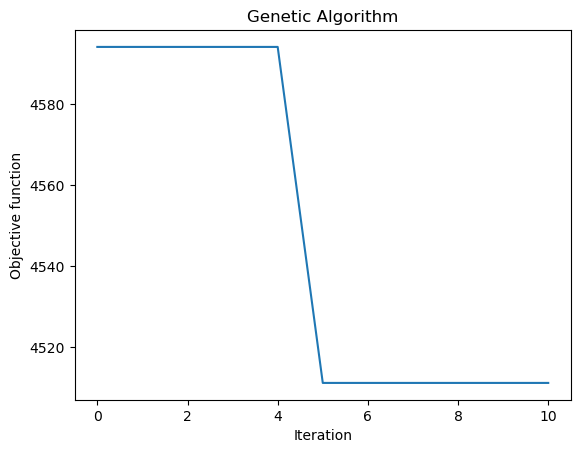

In [88]:
#GA SETUP
varbound = np.array([[16, 64], [1, 2], [0.2, 0.3], [0.0001, 0.01]])
algorithm_param = {'max_num_iteration': 10,
                   'population_size': 10,
                   'mutation_probability': 0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type': 'uniform',
                   'max_iteration_without_improv': 5}

model_ga = ga(
    function=train_model_ga,
    dimension=4,
    variable_type='real',
    variable_boundaries=varbound,
    algorithm_parameters=algorithm_param
)

model_ga.run()
best_params = model_ga.output_dict['variable']

In [89]:
model = LSTMModel(hidden_size=int(best_params[0]), num_layers=int(best_params[1]), dropout=float(best_params[2]))
model.load_state_dict(final_model_state)
model.train()

criterion = nn.MSELoss(reduction="mean")
optimizer = torch.optim.RMSprop(model.parameters(), lr=float(best_params[3]))

for epoch in range(num_epochs):
    for x_batch, y_batch in train_loader:
        output = model(x_batch)
        loss = criterion(output, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")


Epoch [10/200], Loss: 0.029331
Epoch [20/200], Loss: 0.015226
Epoch [30/200], Loss: 0.005690
Epoch [40/200], Loss: 0.002950
Epoch [50/200], Loss: 0.002347
Epoch [60/200], Loss: 0.002270
Epoch [70/200], Loss: 0.002249
Epoch [80/200], Loss: 0.002194
Epoch [90/200], Loss: 0.002127
Epoch [100/200], Loss: 0.002062
Epoch [110/200], Loss: 0.001999
Epoch [120/200], Loss: 0.001941
Epoch [130/200], Loss: 0.001888
Epoch [140/200], Loss: 0.001838
Epoch [150/200], Loss: 0.001793
Epoch [160/200], Loss: 0.001756
Epoch [170/200], Loss: 0.001729
Epoch [180/200], Loss: 0.001712
Epoch [190/200], Loss: 0.001702
Epoch [200/200], Loss: 0.001699


In [90]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    # Hindari pembagian dengan nol
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_idx = y_true != 0
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

def evaluate_model(model, data_loader, scaler):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            output = model(x_batch)

            y_true.extend(y_batch.view(-1).numpy())
            y_pred.extend(output.view(-1).numpy())

    # Inverse transform
    y_true = scaler.inverse_transform(np.array(y_true).reshape(-1, 1)).flatten()
    y_pred = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return mae, rmse, mape, y_true, y_pred

mae_train, rmse_train, mape_train, y_train_true, y_train_pred = evaluate_model(model, train_loader, scaler)
mae_test, rmse_test, mape_test, y_test_true, y_test_pred = evaluate_model(model, test_loader, scaler)

print("\n📊 Evaluasi:")
print(f"Training -> MAE: {mae_train:.2f}, RMSE: {rmse_train:.2f}, MAPE: {mape_train:.2f}%")
print(f"Testing  -> MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}, MAPE: {mape_test:.2f}%")



📊 Evaluasi:
Training -> MAE: 6426.90, RMSE: 8088.76, MAPE: 8.53%
Testing  -> MAE: 4461.63, RMSE: 5156.41, MAPE: 9.95%


In [91]:
# Save full model
torch.save(model.state_dict(), "ga_model_12.pth")
print("✅ Model berhasil disimpan")

✅ Model berhasil disimpan


In [139]:
torch.save(model, "full_lstm_model_batubara.pth")

### **Model Load**

In [14]:
model1 = LSTMModel()
model1.load_state_dict(torch.load("pso_model_12.pth"))
model1.eval()

LSTMModel(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    # Hindari pembagian dengan nol
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_idx = y_true != 0
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

def evaluate_model(model, data_loader, scaler):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            output = model(x_batch)

            y_true.extend(y_batch.view(-1).numpy())
            y_pred.extend(output.view(-1).numpy())

    # Inverse transform
    y_true = scaler.inverse_transform(np.array(y_true).reshape(-1, 1)).flatten()
    y_pred = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return mae, rmse, mape, y_true, y_pred

mae_train, rmse_train, mape_train, y_train_true, y_train_pred = evaluate_model(model1, train_loader, scaler)
mae_test, rmse_test, mape_test, y_test_true, y_test_pred = evaluate_model(model1, test_loader, scaler)

print("\n📊 Evaluasi:")
print(f"Training -> MAE: {mae_train:.2f}, RMSE: {rmse_train:.2f}, MAPE: {mape_train:.2f}%")
print(f"Testing  -> MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}, MAPE: {mape_test:.2f}%")



📊 Evaluasi:
Training -> MAE: 4396.64, RMSE: 6190.90, MAPE: 6.51%
Testing  -> MAE: 2795.16, RMSE: 3555.70, MAPE: 6.28%


### **Forecast**

In [10]:
# Load model hasil tuning
pso_model = LSTMModel()
pso_model.load_state_dict(torch.load("pso_model_12.pth"))
pso_model.eval()

LSTMModel(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [22]:
import torch
import numpy as np

# Fungsi prediksi multi-step rolling
def predict_future(model, data, sequence_length, future_steps, scaler):
    """
    model           : Model LSTM terlatih
    data            : Data terakhir (sudah dinormalisasi)
    sequence_length : Window size yang digunakan
    future_steps    : Jumlah langkah prediksi ke depan
    scaler          : Scaler yang digunakan saat training
    """
    # Pastikan model di evaluation mode
    model.eval()

    # Ambil window terakhir sebagai starting point
    current_sequence = data[-sequence_length:].copy()
    predictions = []

    for _ in range(future_steps):
        # Bentuk input sesuai shape LSTM: (batch, seq_len, features)
        input_seq = torch.tensor(current_sequence, dtype=torch.float32).unsqueeze(0)

        # Prediksi 1 langkah ke depan
        with torch.no_grad():
            pred = model(input_seq).item()

        # Simpan prediksi (dalam bentuk normalized)
        predictions.append(pred)

        # Update sequence dengan menambahkan prediksi ke akhir dan membuang step pertama
        current_sequence = np.append(current_sequence[1:], [[pred]], axis=0)

    # Balikkan hasil prediksi ke skala asli
    predictions = np.array(predictions).reshape(-1, 1)
    predictions_original_scale = scaler.inverse_transform(predictions)

    return predictions_original_scale

# ===== Contoh pemakaian =====
# Misal: sequence_length = 12, prediksi 36 bulan ke depan
future_preds = predict_future(pso_model, test_data, sequence_length=12, future_steps=36, scaler=scaler)

print("Prediksi 36 bulan ke depan:")
print(future_preds)


Prediksi 36 bulan ke depan:
[[45769.65576568]
 [46397.28762107]
 [46931.55490151]
 [47456.25187996]
 [48034.64648038]
 [48554.51981492]
 [49011.04342808]
 [49447.47133173]
 [49821.52146018]
 [50203.94379852]
 [50602.12417556]
 [51046.34689529]
 [51468.7850287 ]
 [51846.11186689]
 [52209.96858924]
 [52562.90775745]
 [52905.6342731 ]
 [53237.74396054]
 [53560.39160733]
 [53874.90040757]
 [54181.92474087]
 [54482.73487357]
 [54777.47515411]
 [55066.04453858]
 [55347.77421251]
 [55623.03707605]
 [55892.65832115]
 [56156.98919571]
 [56416.32561403]
 [56670.93943235]
 [56921.10491272]
 [57167.07947655]
 [57409.07483487]
 [57647.29788713]
 [57881.9290689 ]
 [58113.12956926]]


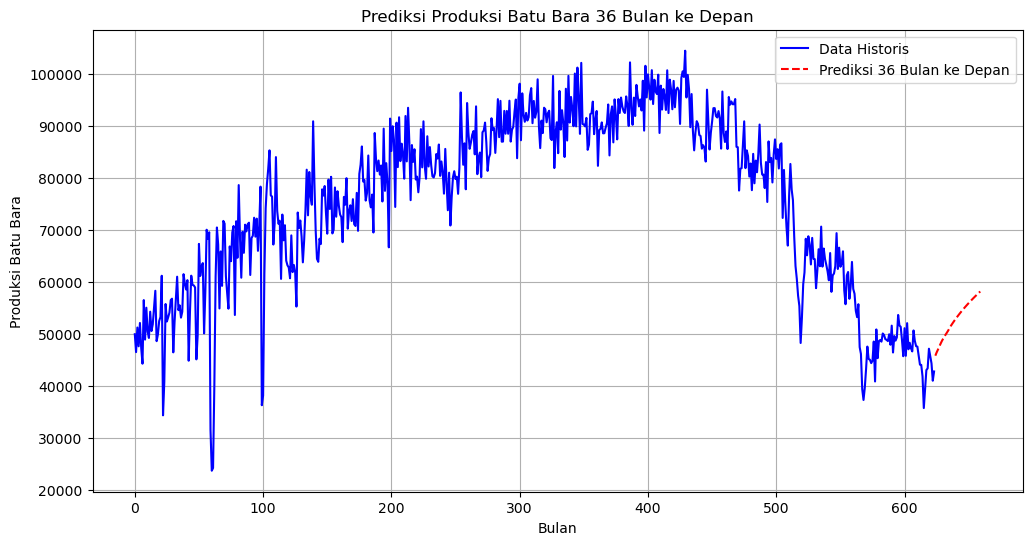

In [23]:
import matplotlib.pyplot as plt

# Ambil data asli dalam skala normal
actual_data = scaler.inverse_transform(data)  # seluruh data asli (sudah dikembalikan ke skala awal)

# Plot data historis
plt.figure(figsize=(12,6))
plt.plot(range(len(actual_data)), actual_data, label="Data Historis", color='blue')

# Plot prediksi masa depan
start_idx = len(actual_data)
end_idx = start_idx + len(future_preds)
plt.plot(range(start_idx, end_idx), future_preds, label="Prediksi 36 Bulan ke Depan", color='red', linestyle='--')

# Hiasan plot
plt.xlabel("Bulan")
plt.ylabel("Produksi Batu Bara")
plt.title("Prediksi Produksi Batu Bara 36 Bulan ke Depan")
plt.legend()
plt.grid(True)
plt.show()


### **Visualization**

In [9]:
# Load model hasil tuning
pso_model = LSTMModel()
pso_model.load_state_dict(torch.load("pso_model_12.pth"))
pso_model.eval()

LSTMModel(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [10]:
import torch
import re
from collections import defaultdict

def infer_lstm_params_from_state(state_dict):
    # Ambil semua weight_ih_l* untuk mendeteksi jumlah layer dan hidden_size
    layer_weights = [k for k in state_dict.keys() if re.match(r"lstm\.weight_ih_l\d+", k)]
    num_layers = len(layer_weights)

    # Ambil satu layer pertama untuk hitung hidden_size
    first_weight = state_dict[layer_weights[0]]
    hidden_size = first_weight.shape[0] // 4  # LSTM punya 4 gate
    return hidden_size, num_layers

# === PAKAI ===
pth_file = "gs_model_12.pth"  # ubah sesuai model
state = torch.load(pth_file)

# Jika file disimpan murni state_dict
if isinstance(state, dict) and 'model_state_dict' in state:
    state_dict = state['model_state_dict']
else:
    state_dict = state

hidden_size, num_layers = infer_lstm_params_from_state(state_dict)
print(f"Detected hidden_size: {hidden_size}, num_layers: {num_layers}")

# Inisialisasi model dengan param yang benar
gs_model = LSTMModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers, dropout=0.2)
gs_model.load_state_dict(state_dict)
gs_model.eval()


Detected hidden_size: 16, num_layers: 1


LSTMModel(
  (lstm): LSTM(1, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [11]:
import torch
import re
from collections import defaultdict

def infer_lstm_params_from_state(state_dict):
    # Ambil semua weight_ih_l* untuk mendeteksi jumlah layer dan hidden_size
    layer_weights = [k for k in state_dict.keys() if re.match(r"lstm\.weight_ih_l\d+", k)]
    num_layers = len(layer_weights)

    # Ambil satu layer pertama untuk hitung hidden_size
    first_weight = state_dict[layer_weights[0]]
    hidden_size = first_weight.shape[0] // 4  # LSTM punya 4 gate
    return hidden_size, num_layers

# === PAKAI ===
pth_file = "ga_model_12.pth"  # ubah sesuai model
state = torch.load(pth_file)

# Jika file disimpan murni state_dict
if isinstance(state, dict) and 'model_state_dict' in state:
    state_dict = state['model_state_dict']
else:
    state_dict = state

hidden_size, num_layers = infer_lstm_params_from_state(state_dict)
print(f"Detected hidden_size: {hidden_size}, num_layers: {num_layers}")

# Inisialisasi model dengan param yang benar
ga_model = LSTMModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers, dropout=0.2)
ga_model.load_state_dict(state_dict)
ga_model.eval()


Detected hidden_size: 24, num_layers: 1


LSTMModel(
  (lstm): LSTM(1, 24, batch_first=True)
  (fc): Linear(in_features=24, out_features=1, bias=True)
)

In [12]:
# --- Fungsi MAPE ---
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_idx = y_true != 0
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

# --- Fungsi evaluasi ---
def evaluate_model(model, data_loader, scaler):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            output = model(x_batch)
            y_true.extend(y_batch.view(-1).numpy())
            y_pred.extend(output.view(-1).numpy())

    # Balik ke skala asli
    y_true = scaler.inverse_transform(np.array(y_true).reshape(-1, 1)).flatten()
    y_pred = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return mae, rmse, mape, y_true, y_pred

In [13]:
# --- Evaluasi & dapatkan data untuk plot ---
mae_pso, rmse_pso, mape_pso, y_true_pso, y_pred_pso = evaluate_model(pso_model, test_loader, scaler)
mae_gs, rmse_gs, mape_gs, y_true_gs, y_pred_gs = evaluate_model(gs_model, test_loader, scaler)
mae_ga, rmse_ga, mape_ga, y_true_ga, y_pred_ga = evaluate_model(ga_model, test_loader, scaler)

In [14]:
print(f"Testing  -> MAE: {mae_pso:.2f}, RMSE: {rmse_pso:.2f}, MAPE: {mape_pso:.2f}%")

Testing  -> MAE: 2795.16, RMSE: 3555.70, MAPE: 6.28%


In [16]:
# Pastikan kolom 'Year' bertipe datetime
df['Year'] = pd.to_datetime(df['Year'])

# Buat label bulan_tahun
df['Month_Year'] = df['Year'].dt.strftime('%b_%Y')  # contoh: Jan_1973

def plot_predictions_subplot(models, model_names, train_loader, test_loader, scaler, split_idx, zoom=False):
    plt.figure(figsize=(18, 10))

    # Ambil label waktu
    labels = df['Month_Year'].values  # array string label waktu

    for i, (model, name) in enumerate(zip(models, model_names)):
        _, _, _, y_train_true, y_train_pred = evaluate_model(model, train_loader, scaler)
        _, _, _, y_test_true, y_test_pred = evaluate_model(model, test_loader, scaler)

        # Gabungkan train+test
        y_true = np.concatenate([y_train_true, y_test_true])
        y_pred = np.concatenate([y_train_pred, y_test_pred])

        if zoom:
            start_idx = split_idx - 50
            end_idx = split_idx + len(y_test_true)
            x = labels[start_idx:end_idx]  # pakai label bulan_tahun
            y_true = y_true[start_idx:end_idx]
            y_pred = y_pred[start_idx:end_idx]
            split_line = 50  # posisi garis di zoom
        else:
            x = labels
            split_line = split_idx

        plt.subplot(3, 1, i+1)
        plt.plot(x, y_true, label='Actual', color='black', linewidth=1)
        plt.plot(x, y_pred, label='Predicted', color='red', linestyle='--', linewidth=1)
        plt.axvline(split_line, color='blue', linestyle=':', linewidth=1.5, label='Train/Test Split')
        plt.title(f"{name} - Actual vs Predicted", fontsize=14)
        plt.ylabel("Target Value")
        plt.grid(True)
        plt.xticks(rotation=45)  # miringkan label supaya tidak bertumpuk
        if i == 0:
            plt.legend()

    plt.xlabel("Bulan_Tahun")
    plt.tight_layout()
    plt.show()


In [28]:
def plot_predictions_subplot(models, model_names, train_loader, test_loader, scaler, split_idx):
    plt.figure(figsize=(18, 10))

    # Pastikan kolom datetime & label bulan_tahun
    df['Year'] = pd.to_datetime(df['Year'])
    df['Month_Year'] = df['Year'].dt.strftime('%b_%Y')

    for i, (model, name) in enumerate(zip(models, model_names)):
        # Prediksi train & test
        _, _, _, y_train_true, y_train_pred = evaluate_model(model, train_loader, scaler)
        _, _, _, y_test_true, y_test_pred = evaluate_model(model, test_loader, scaler)

        # Gabungkan train+test
        y_true = np.concatenate([y_train_true, y_test_true])
        y_pred = np.concatenate([y_train_pred, y_test_pred])

        # Label waktu sesuai panjang data
        labels = df['Month_Year'].iloc[:len(y_true)].values

        # Subplot
        plt.subplot(3, 1, i+1)
        plt.plot(labels, y_true, label='Actual', color='black', linewidth=1)
        plt.plot(labels, y_pred, label='Predicted', color='red', linestyle='--', linewidth=1)
        plt.axvline(split_idx, color='blue', linestyle=':', linewidth=3, label='Train/Test Split')

        plt.title(f"{name} - Actual vs Predicted", fontsize=14)
        plt.ylabel("Target Value")
        plt.grid(True)

        # Tampilkan hanya 5 tick di X-axis
        step = max(1, len(labels) // 5)
        plt.xticks(np.arange(0, len(labels), step), labels[::step], rotation=45)

        if i == 0:
            plt.legend()

    plt.xlabel("Month_Year")
    plt.tight_layout()
    plt.show()


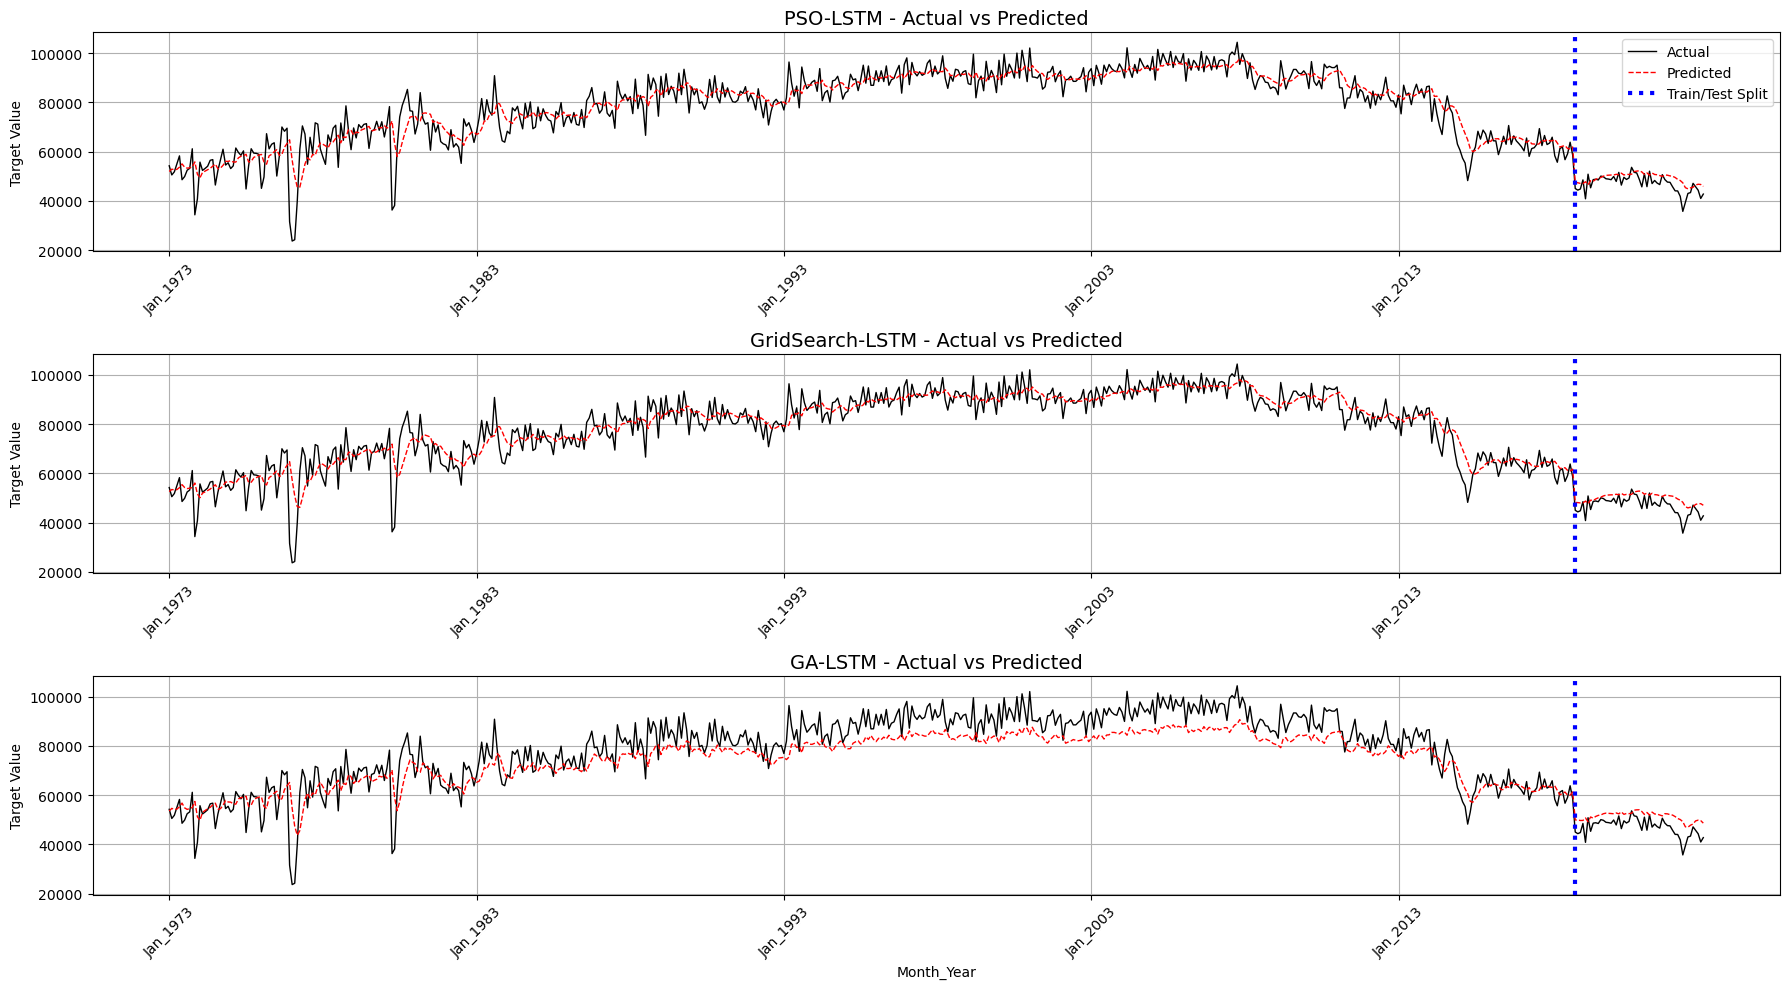

In [29]:
models = [pso_model, gs_model, ga_model]
model_names = ["PSO-LSTM", "GridSearch-LSTM", "GA-LSTM"]
split_idx = len(train_dataset)

plot_predictions_subplot(models, model_names, train_loader, test_loader, scaler, split_idx)

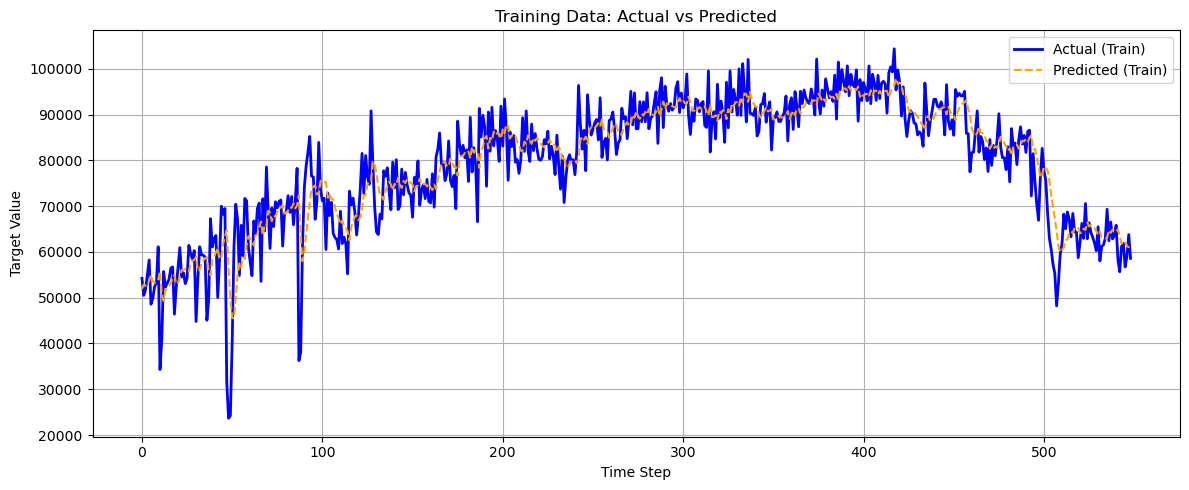

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12, 5))
plt.plot(y_train_true, label='Actual (Train)', color='blue', linewidth=2)
plt.plot(y_train_pred, label='Predicted (Train)', color='orange', linestyle='--')
plt.title('Training Data: Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


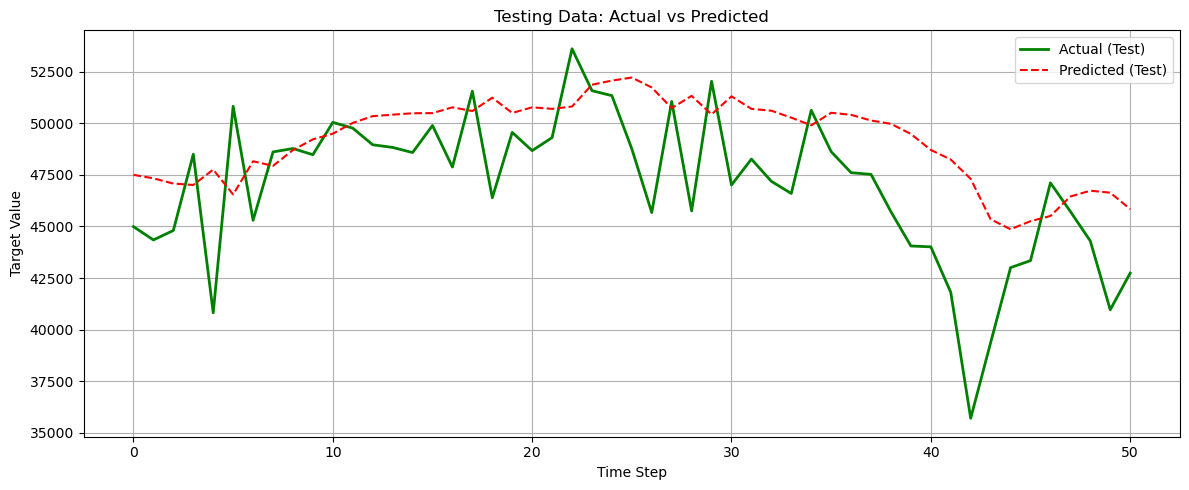

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_true, label='Actual (Test)', color='green', linewidth=2)
plt.plot(y_test_pred, label='Predicted (Test)', color='red', linestyle='--')
plt.title('Testing Data: Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


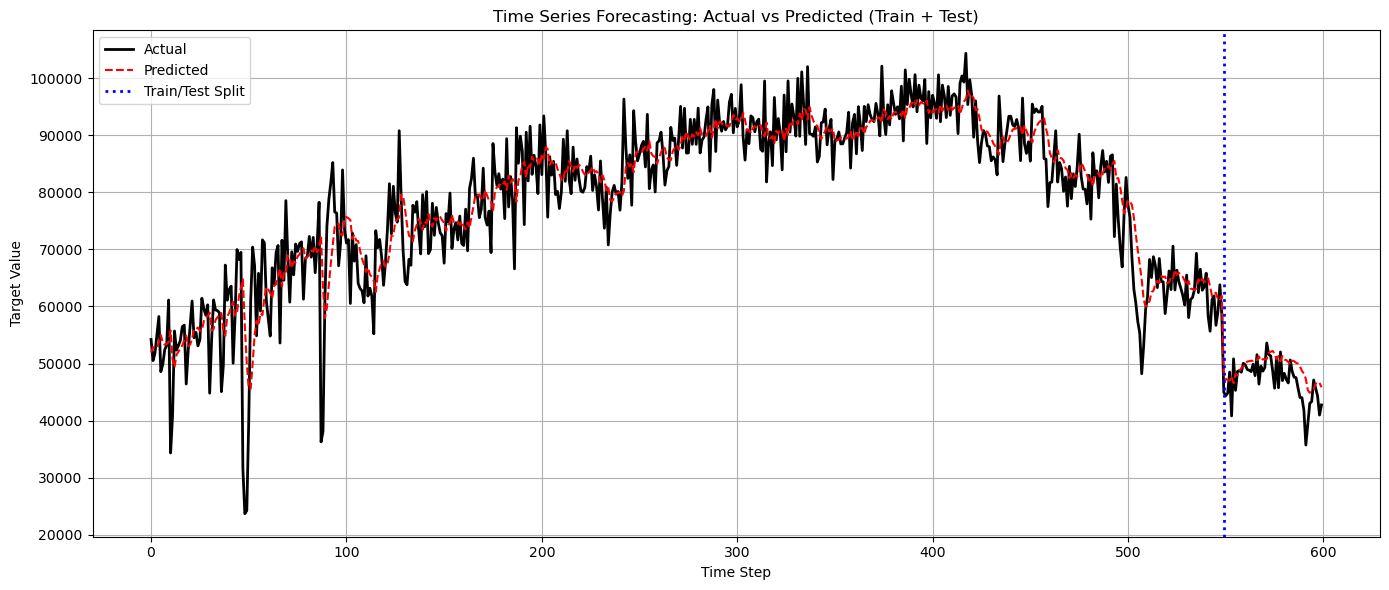

In [ ]:
# Gabungkan hasil prediksi dan nilai aktual
y_all_true = np.concatenate([y_train_true, y_test_true])
y_all_pred = np.concatenate([y_train_pred, y_test_pred])

# Buat pembatas antara train dan test
split_index = len(y_train_pred)

plt.figure(figsize=(14, 6))

plt.plot(y_all_true, label='Actual', color='black', linewidth=2)
plt.plot(y_all_pred, label='Predicted', color='red', linestyle='--')

# Tambahkan garis vertikal untuk memisahkan train/test
plt.axvline(x=split_index, color='blue', linestyle=':', linewidth=2, label='Train/Test Split')

# Anotasi
plt.title('Time Series Forecasting: Actual vs Predicted (Train + Test)')
plt.xlabel('Time Step')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
